<a href="https://colab.research.google.com/github/sophiezydfifi/207fall-project-ding-peteh-valadez-zhang/blob/main/207_Milestone_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Challenges and Pre-processing**


In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import files

In [79]:
# upload the file and please replace the file link
df = pd.read_csv("/content/NBA Player Stats and Salaries_2010-2025.csv")
print(df.shape)
df.head()

(7298, 31)


Player    Salary  Year Pos  Age Team   G  GS    MP   FG  ...  \
0       Kobe Bryant  23034375  2010  SG   31  LAL  73  73  38.8  9.8  ...   
1   Jermaine O'Neal  23016000  2010   C   31  MIA  70  70  28.4  5.6  ...   
2     Tracy McGrady  22843124  2010  SG   30  NYK  30  24  22.4  3.0  ...   
3        Tim Duncan  22183220  2010   C   33  SAS  78  77  31.3  7.2  ...   
4  Shaquille O'Neal  21000000  2010   C   37  CLE  53  53  23.4  4.9  ...   

     FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0  0.811  1.1  4.3   5.4  5.0  1.5  0.3  3.2  2.6  27.0  
1  0.720  1.8  5.2   6.9  1.3  0.4  1.4  1.8  3.0  13.6  
2  0.746  0.7  2.4   3.1  3.3  0.5  0.5  1.5  1.3   8.2  
3  0.725  2.8  7.3  10.1  3.2  0.6  1.5  1.8  1.9  17.9  
4  0.496  1.8  4.9   6.7  1.5  0.3  1.2  2.0  3.2  12.0  

[5 rows x 31 columns]

In [80]:
# Quick structure overview
df.info()

# Check missing values
df.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7298 entries, 0 to 7297
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7298 non-null   object 
 1   Salary  7298 non-null   int64  
 2   Year    7298 non-null   int64  
 3   Pos     7298 non-null   object 
 4   Age     7298 non-null   int64  
 5   Team    7298 non-null   object 
 6   G       7298 non-null   int64  
 7   GS      7298 non-null   int64  
 8   MP      7298 non-null   float64
 9   FG      7298 non-null   float64
 10  FGA     7298 non-null   float64
 11  FG%     7278 non-null   float64
 12  3P      7298 non-null   float64
 13  3PA     7298 non-null   float64
 14  3P%     6713 non-null   float64
 15  2P      7298 non-null   float64
 16  2PA     7298 non-null   float64
 17  2P%     7253 non-null   float64
 18  eFG%    7278 non-null   float64
 19  FT      7298 non-null   float64
 20  FTA     7298 non-null   float64
 21  FT%     7096 non-null   float64
 22  

3P%       585
FT%       202
2P%        45
FG%        20
eFG%       20
Pos         0
Player      0
G           0
Team        0
GS          0
MP          0
FGA         0
Age         0
Salary      0
Year        0
3PA         0
3P          0
FG          0
2PA         0
2P          0
dtype: int64

In [81]:
# For the missing values. They are all data derived from other non-missing columns. Hence I can fill percentage columns with 0
perc_cols = ["3P%", "FT%", "2P%", "FG%", "eFG%"]
df[perc_cols] = df[perc_cols].fillna(0)

# Double check
df[perc_cols].isnull().sum()

3P%     0
FT%     0
2P%     0
FG%     0
eFG%    0
dtype: int64

In [82]:
# I want to adjust all the salary from different years to the level of 2025 based on the NBA cap. (https://www.spotrac.com/nba/cba/)
#Salary Cap Maximum values (from  the NBA salary Cap table, 2010–2025)
cap_data = {
    "Year": [
        2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024, 2025
    ],
    "Cap": [
        58040000, 58044000, 58044000, 58679000,
        63065000, 70000000, 94143000, 99093000,
        101869000, 109140000, 109140000, 112414000,
        123655000, 136021000, 140588000, 154647000
    ]
}

cap_df = pd.DataFrame(cap_data)
cap_df

Year        Cap
0   2010   58040000
1   2011   58044000
2   2012   58044000
3   2013   58679000
4   2014   63065000
5   2015   70000000
6   2016   94143000
7   2017   99093000
8   2018  101869000
9   2019  109140000
10  2020  109140000
11  2021  112414000
12  2022  123655000
13  2023  136021000
14  2024  140588000
15  2025  154647000

In [83]:
# Merge salary cap info into NBA dataset
df_adj = df.merge(cap_df, on="Year", how="left")
# Define 2025 cap
cap_2025 = 154647000

# Adjust all salaries to 2025 cap level
df_adj["Salary_2025_Adjusted"] = df_adj["Salary"] * (cap_2025 / df_adj["Cap"])

In [84]:
# encode categorical values like position and team
df_working = pd.get_dummies(df_adj, columns=["Pos", "Team"], drop_first=True)

In [213]:
#Classify the salary into low, mid and high categories
# Define quantile cutoffs
q33 = df_working["Salary_2025_Adjusted"].quantile(0.33)
q66 = df_working["Salary_2025_Adjusted"].quantile(0.66)


# Create a categorical variable for salary tiers
def categorize_salary(salary):
    if salary <= q33:
        return "Low"
    elif salary <= q66:
        return "Medium"
    else:
        return "High"

class_order = ["Low", "Medium", "High"]

df_working["Salary_Tier"] = df_working["Salary_2025_Adjusted"].apply(categorize_salary)

# Quick check of class balance
print(df_working["Salary_Tier"].value_counts())



Salary_Tier
High      2481
Low       2409
Medium    2408
Name: count, dtype: int64


In [214]:
# check shape to head into splitting
print('Shape of data', df_working.shape)
df_working.head(800)

Shape of data (7298, 78)


Player    Salary  Year  Age   G  GS    MP   FG   FGA    FG%  \
0           T.J. Ford   8500000  2010   26  47  32  25.3  4.0   8.9  0.445   
1      Derrick Favors  17650000  2020   28  51  49  24.4  4.1   6.6  0.617   
2         Nolan Smith   1365720  2012   23  44   4  12.3  1.5   4.1  0.372   
3       Hedo Turkoglu  12000000  2013   33  11   1  17.2  1.3   4.8  0.264   
4         Erick Green    507336  2015   23  43   1   9.5  1.4   3.8  0.377   
..                ...       ...   ...  ...  ..  ..   ...  ...   ...    ...   
795    Daniel Gafford    898310  2020   21  43   7  14.2  2.2   3.1  0.701   
796       Danny Green  14634146  2020   32  68  68  24.8  2.9   7.0  0.416   
797  Tristan Thompson  11501738  2022   30  57   6  15.7  2.5   4.7  0.528   
798         Alex Sarr  11245680  2025   19  67  67  27.1  4.9  12.4  0.394   
799     Nick Collison   3750000  2017   36  20   0   6.4  0.7   1.2  0.609   

     ...  Team_ORL  Team_PHI  Team_PHO  Team_POR  Team_SAC  Team_SAS  \
0    ...     False     False     False     False     False     False   
1    ...     False     False     False     False     False     False   
2    ...     False     False     False      True     False     False   
3    ...      True     False     False     False     False     False   
4    ...     False     False     False     False     False     False   
..   ...       ...       ...       ...       ...       ...       ...   
795  ...     False     False     False     False     False     False   
796  ...     False     False     False     False     False     False   
797  ...     False     False     False     False     False     False   
798  ...     False     False     False     False     False     False   
799  ...     False     False     False     False     False     False   

     Team_TOR  Team_UTA  Team_WAS  Salary_Tier  
0       False     False     False         High  
1       False     False     False         High  
2       False     False     False       Medium  
3       False     False     False         High  
4       False     False     False          Low  
..        ...       ...       ...          ...  
795     False     False     False          Low  
796     False     False     False         High  
797     False     False     False         High  
798     False     False      True         High  
799     False     False     False       Medium  

[800 rows x 78 columns]

In [87]:
# permutation for shuffling
np.random.seed(0)
n   = len(df_working)
idx = np.random.permutation(n)

# reset and clean up the index from gaps in preprocessing
df_working = df_working.reset_index(drop = True).iloc[idx].reset_index(drop = True)

In [88]:
# features of interest
num_features = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
cat_features = ['Pos_C-PF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-C', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF',
                'Team_BOS', 'Team_BRK', 'Team_CHA', 'Team_CHI', 'Team_CHO', 'Team_CLE', 'Team_DAL', 'Team_DEN', 'Team_DET', 'Team_GSW', 'Team_HOU', 'Team_IND', 'Team_LAC', 'Team_LAL', 'Team_MEM', 'Team_MIA',
                'Team_MIL', 'Team_MIN', 'Team_NJN', 'Team_NOH', 'Team_NOP', 'Team_NYK', 'Team_OKC', 'Team_ORL', 'Team_PHI', 'Team_PHO', 'Team_POR', 'Team_SAC', 'Team_SAS', 'Team_TOR', 'Team_UTA', 'Team_WAS']

# define features for the training
X = df_working[num_features + cat_features]  # drop columns I don't want to use

y = df_working["Salary_2025_Adjusted"]

In [89]:
# split data 60 train 20 val 20 test
x_train, x_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.40, random_state = 1234)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size = 0.50, random_state = 1234)

In [90]:
#Many ML models (regression, KNN, neural nets) need features on similar scales.
#Tree models (Random Forest, Gradient Boosting) don’t need scaling, but it’s fine to keep a standardized version for consistency.
from sklearn.preprocessing import StandardScaler

#numeric standardization
scaler = StandardScaler()

# fits standardization on x_train keeps column names and preserve row shuffle
x_train_num = pd.DataFrame(
    scaler.fit_transform(x_train[num_features]),
    columns = num_features,
    index = x_train.index
)

# fits same scaler on x_val keeps column names and preserve row shuffle
x_val_num = pd.DataFrame(
    scaler.transform(x_val[num_features]),
    columns = num_features,
    index = x_val.index
)

# fits same scaler on x_test keeps column names and preserve rows
x_test_num = pd.DataFrame(
    scaler.transform(x_test[num_features]),
    columns = num_features,
    index = x_test.index
)

In [91]:
# put together standardized features
x_train_scaled = pd.concat([x_train_num, x_train[cat_features]], axis = 1)
x_val_scaled = pd.concat([x_val_num, x_val[cat_features]], axis = 1)
x_test_scaled = pd.concat([x_test_num, x_test[cat_features]], axis = 1)

print("x_train_scaled: ", x_train_scaled.shape, " y_train: ", y_train.shape)
print("x_val_scaled: ", x_val_scaled.shape,   " y_val: ", y_val.shape)
print("x_test_scaled: ", x_test_scaled.shape,  " y_test: ", y_test.shape)

x_train_scaled:  (4378, 72)  y_train:  (4378,)
x_val_scaled:  (1460, 72)  y_val:  (1460,)
x_test_scaled:  (1460, 72)  y_test:  (1460,)


# **EDA and visualizations**

In [92]:
# plot the salary graph to show distribution
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

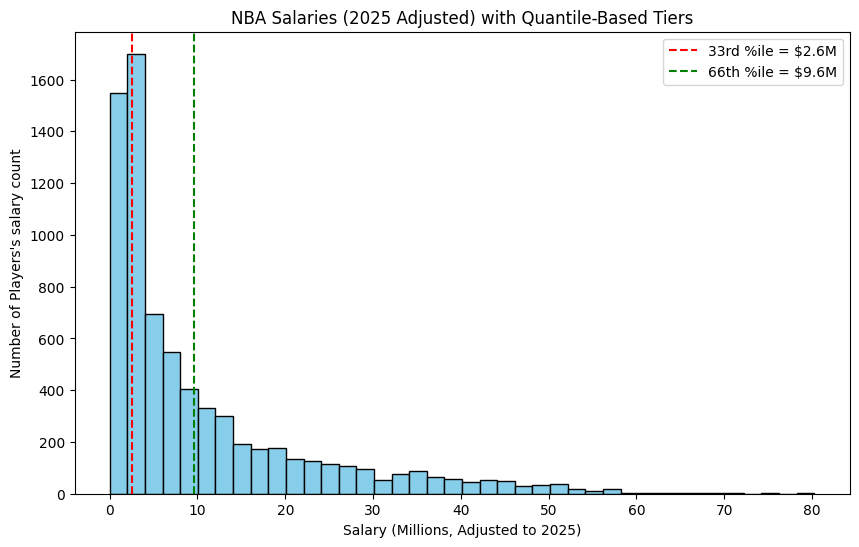

In [188]:
plt.figure(figsize=(10,6))
plt.hist(df_adj["Salary_2025_Adjusted"]/1e6, bins=40, color="skyblue", edgecolor="black")
plt.axvline(q33/1e6, color="red", linestyle="--", label=f"33rd %ile = ${q33/1e6:.1f}M")
plt.axvline(q66/1e6, color="green", linestyle="--", label=f"66th %ile = ${q66/1e6:.1f}M")
plt.title("NBA Salaries (2025 Adjusted) with Quantile-Based Tiers")
plt.xlabel("Salary (Millions, Adjusted to 2025)")
plt.ylabel("Number of Players's salary count")
plt.legend()
plt.show()

In [94]:
# scatter plolt salary vs season pts avg
brush = alt.selection_interval()
scatter = alt.Chart(df_adj).mark_circle().encode(
    x = alt.X("PTS:Q", title = "Season Points"),
    y = alt.Y("Salary:Q", title = "Salary"),
    color = alt.condition(brush, "Pos:N", alt.value("lightgray")),
    tooltip = ["Player","Team","Year","PTS","Salary","Pos"]
).add_params(brush).properties(title="Points vs Salary")

In [95]:
scatter

alt.Chart(...)

In [142]:
cor_features = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Salary_2025_Adjusted']

In [143]:
# numeric features correlation heatmap
corr = df_adj[cor_features].corr().stack().reset_index()
corr.columns = ["feature_x","feature_y","corr"]

heatmap = alt.Chart(corr).mark_rect().encode(
    x = alt.X("feature_x:N", sort = cor_features, title = ""),
    y = alt.Y("feature_y:N", sort = cor_features, title = ""),
    color = alt.Color("corr:Q", scale = alt.Scale(scheme = "redblue", domain = [-1,1])),
    tooltip = ["feature_x","feature_y","corr"]
).properties(title = "Salary Correlation Heatmap")

In [144]:
heatmap

alt.Chart(...)

# Feature Selection Based on EDA

In [145]:
target = "Salary_2025_Adjusted"

# Keep only correlations involving the target variable
corr_target = corr[
    ((corr['feature_x'] == target) | (corr['feature_y'] == target)) &
    (corr['feature_x'] != corr['feature_y'])
].copy()

# Sort by absolute correlation or raw correlation (your choice)
corr_target_sorted = corr_target.sort_values(by='corr', ascending=False)

print(corr_target_sorted)

                feature_x             feature_y      corr
727  Salary_2025_Adjusted                   PTS  0.674662
701                   PTS  Salary_2025_Adjusted  0.674662
134                    FG  Salary_2025_Adjusted  0.671015
706  Salary_2025_Adjusted                    FG  0.671015
707  Salary_2025_Adjusted                   FGA  0.654072
161                   FGA  Salary_2025_Adjusted  0.654072
296                    2P  Salary_2025_Adjusted  0.634890
712  Salary_2025_Adjusted                    2P  0.634890
713  Salary_2025_Adjusted                   2PA  0.630962
323                   2PA  Salary_2025_Adjusted  0.630962
404                    FT  Salary_2025_Adjusted  0.626624
716  Salary_2025_Adjusted                    FT  0.626624
717  Salary_2025_Adjusted                   FTA  0.622432
431                   FTA  Salary_2025_Adjusted  0.622432
107                    MP  Salary_2025_Adjusted  0.611773
705  Salary_2025_Adjusted                    MP  0.611773
647           

In [146]:
# permutation for shuffling
np.random.seed(0)
n   = len(df_working)
idx = np.random.permutation(n)

# reset and clean up the index from gaps in preprocessing
df_working = df_working.reset_index(drop = True).iloc[idx].reset_index(drop = True)

In [147]:
# features of interest
selected_features = ['DRB', 'AST', 'TOV', 'PTS']
# cat_features = ['Pos_C-PF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-C', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF',
               # 'Team_BOS', 'Team_BRK', 'Team_CHA', 'Team_CHI', 'Team_CHO', 'Team_CLE', 'Team_DAL', 'Team_DEN', 'Team_DET', 'Team_GSW', 'Team_HOU', 'Team_IND', 'Team_LAC', 'Team_LAL', 'Team_MEM', 'Team_MIA',
               # 'Team_MIL', 'Team_MIN', 'Team_NJN', 'Team_NOH', 'Team_NOP', 'Team_NYK', 'Team_OKC', 'Team_ORL', 'Team_PHI', 'Team_PHO', 'Team_POR', 'Team_SAC', 'Team_SAS', 'Team_TOR', 'Team_UTA', 'Team_WAS']

# define features for the training
# X = df_working[num_features + cat_features]  # drop columns I don't want to use
X = df_working[selected_features]

y = df_working["Salary_2025_Adjusted"]

In [148]:
# split data 60 train 20 val 20 test
x_train, x_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.40, random_state = 1234)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size = 0.50, random_state = 1234)

In [151]:
#Many ML models (regression, KNN, neural nets) need features on similar scales.
#Tree models (Random Forest, Gradient Boosting) don’t need scaling, but it’s fine to keep a standardized version for consistency.
from sklearn.preprocessing import StandardScaler

#numeric standardization
scaler = StandardScaler()

# fits standardization on x_train keeps column names and preserve row shuffle
x_train_num = pd.DataFrame(
    scaler.fit_transform(x_train[selected_features]),
    columns = selected_features,
    index = x_train.index
)

# fits same scaler on x_val keeps column names and preserve row shuffle
x_val_num = pd.DataFrame(
    scaler.transform(x_val[selected_features]),
    columns = selected_features,
    index = x_val.index
)

# fits same scaler on x_test keeps column names and preserve rows
x_test_num = pd.DataFrame(
    scaler.transform(x_test[selected_features]),
    columns = selected_features,
    index = x_test.index
)

In [152]:
# put together standardized features
# x_train_scaled = pd.concat([x_train_num, x_train[cat_features]], axis = 1)
# x_val_scaled = pd.concat([x_val_num, x_val[cat_features]], axis = 1)
# x_test_scaled = pd.concat([x_test_num, x_test[cat_features]], axis = 1)

print("x_train_scaled: ", x_train_num.shape, " y_train: ", y_train.shape)
print("x_val_scaled: ", x_val_num.shape,   " y_val: ", y_val.shape)
print("x_test_scaled: ", x_test_num.shape,  " y_test: ", y_test.shape)

x_train_scaled:  (4378, 4)  y_train:  (4378,)
x_val_scaled:  (1460, 4)  y_val:  (1460,)
x_test_scaled:  (1460, 4)  y_test:  (1460,)


# Baseline

In [189]:
# imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report

In [190]:
# baseline of linear regression
lr = LinearRegression()
lr.fit(x_train_num, y_train)

LinearRegression()

In [191]:
# salary predictions
y_train_pred = lr.predict(x_train_num)
y_val_pred = lr.predict(x_val_num)

In [192]:
# RMSE
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

In [193]:
print("Training RMSE: ", train_rmse)
print("\n")
print("Validation RMSE: ", val_rmse)

Training RMSE:  8784014.598962283


Validation RMSE:  8638819.197132621


In [195]:
# categorize_salary and compare to true category
y_train_pred_tiers = pd.Series(y_train_pred).apply(categorize_salary)
y_train_true_tiers = df_working.loc[y_train.index, "Salary_Tier"]

y_val_pred_tiers = pd.Series(y_val_pred).apply(categorize_salary)
y_val_true_tiers = df_working.loc[y_val.index, "Salary_Tier"]

In [196]:
# confusion matrix and accuracy
print("Train Accuracy:", accuracy_score(y_train_true_tiers, y_train_pred_tiers))
print("\nTrain Confusion Matrix:\n", confusion_matrix(y_train_true_tiers, y_train_pred_tiers))
print("\nTrain Classification Report:\n",
      classification_report(y_train_true_tiers, y_train_pred_tiers, target_names = class_order))

print("Val Accuracy:", accuracy_score(y_val_true_tiers, y_val_pred_tiers))
print("\nVal Confusion Matrix:\n", confusion_matrix(y_val_true_tiers, y_val_pred_tiers))
print("\nVal Classification Report:\n",
      classification_report(y_val_true_tiers, y_val_pred_tiers, target_names = class_order))

Train Accuracy: 0.5541343079031521

Train Confusion Matrix:
 [[1177   32  252]
 [ 191  586  689]
 [ 584  204  663]]

Train Classification Report:
               precision    recall  f1-score   support

         Low       0.60      0.81      0.69      1461
      Medium       0.71      0.40      0.51      1466
        High       0.41      0.46      0.43      1451

    accuracy                           0.55      4378
   macro avg       0.58      0.55      0.55      4378
weighted avg       0.58      0.55      0.55      4378

Val Accuracy: 0.5438356164383562

Val Confusion Matrix:
 [[388  19  99]
 [ 75 197 201]
 [211  61 209]]

Val Classification Report:
               precision    recall  f1-score   support

         Low       0.58      0.77      0.66       506
      Medium       0.71      0.42      0.53       473
        High       0.41      0.43      0.42       481

    accuracy                           0.54      1460
   macro avg       0.57      0.54      0.54      1460
weighted avg  

In [197]:
# run on test data
y_test_pred = lr.predict(x_test_num)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Testing RMSE: ", test_rmse)

y_test_pred_tiers = pd.Series(y_test_pred).apply(categorize_salary)
y_test_true_tiers = df_working.loc[y_test.index, "Salary_Tier"]

Testing RMSE:  8760426.433082592


In [198]:
print("Accuracy:", accuracy_score(y_test_true_tiers, y_test_pred_tiers))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tiers, y_test_pred_tiers))
print("\nClassification Report:\n", classification_report(y_test_true_tiers, y_test_pred_tiers, target_names=class_order))

Accuracy: 0.5657534246575342

Confusion Matrix:
 [[403  12  99]
 [ 62 207 201]
 [191  69 216]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.61      0.78      0.69       514
      Medium       0.72      0.44      0.55       470
        High       0.42      0.45      0.44       476

    accuracy                           0.57      1460
   macro avg       0.58      0.56      0.56      1460
weighted avg       0.58      0.57      0.56      1460



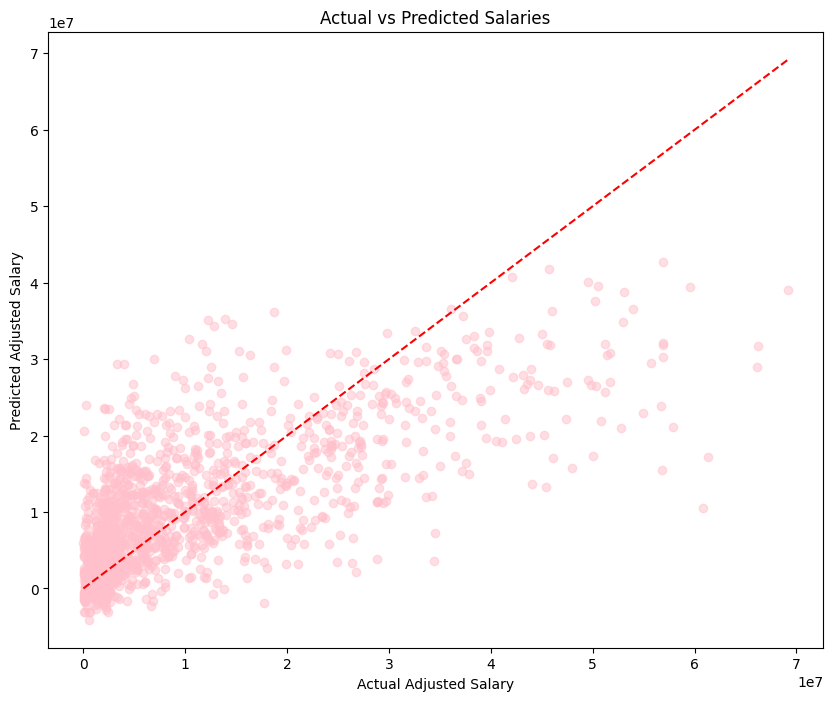

In [199]:
# plotting test data results
plt.figure(figsize = (10, 8))
plt.scatter(y_test, y_test_pred, alpha = 0.5, color = "pink")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Adjusted Salary")
plt.ylabel("Predicted Adjusted Salary")
plt.title("Actual vs Predicted Salaries")
plt.show()

# XGBoost Baseline

In [200]:
from xgboost import XGBRegressor

In [201]:
# xgb model
xgb = XGBRegressor(
    # regression; minimize squared error
    objective = "reg:squarederror",
    # max trees
    n_estimators = 300,
    learning_rate = 0.05,
    # max depth
    max_depth = 5,
    # use 80% of rows
    subsample = 0.8,
    # use 80% of features
    colsample_bytree = 0.8,
    # track rmse
    eval_metric = "rmse",
    early_stopping_rounds = 30,
    random_state = 123,
    n_jobs = -1
)


In [202]:
# fit model on train and val data
xgb.fit(
    x_train_num, y_train,
    eval_set=[(x_train_num, y_train), (x_val_num, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [203]:
# salary predictions for all data
y_train_pred = xgb.predict(x_train_num)
y_val_pred = xgb.predict(x_val_num)
y_test_pred = xgb.predict(x_test_num)

In [204]:
# MSE and RMSE
def print_reg_results(split, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{split} MSE: {mse:,.2f}")
    print(f"{split} RMSE: {rmse:,.2f}\n")

print_reg_results("Train", y_train, y_train_pred)
print_reg_results("Val", y_val,   y_val_pred)
print_reg_results("Test", y_test,  y_test_pred)


Train MSE: 57,072,078,724,831.39
Train RMSE: 7,554,606.46

Val MSE: 70,900,522,350,781.06
Val RMSE: 8,420,244.79

Test MSE: 75,326,653,804,567.11
Test RMSE: 8,679,092.91



In [205]:
# categorize_salary and compare to true category
y_train_true_tiers = df_working.loc[y_train.index, "Salary_Tier"]
y_train_pred_tiers = pd.Series(y_train_pred).apply(categorize_salary)
y_val_true_tiers   = df_working.loc[y_val.index,   "Salary_Tier"]
y_val_pred_tiers   = pd.Series(y_val_pred).apply(categorize_salary)
y_test_true_tiers  = df_working.loc[y_test.index,  "Salary_Tier"]
y_test_pred_tiers  = pd.Series(y_test_pred).apply(categorize_salary)

In [206]:
# confusion matrix and accuracy
print("Train Accuracy:", accuracy_score(y_train_true_tiers, y_train_pred_tiers))
print("\nTrain Confusion Matrix:\n", confusion_matrix(y_train_true_tiers, y_train_pred_tiers))
print("\nTrain Classification Report:\n", classification_report(y_train_true_tiers, y_train_pred_tiers, target_names = class_order))

print("Val Accuracy:", accuracy_score(y_val_true_tiers, y_val_pred_tiers))
print("\nVal Confusion Matrix:\n", confusion_matrix(y_val_true_tiers, y_val_pred_tiers))
print("\nVal Classification Report:\n", classification_report(y_val_true_tiers, y_val_pred_tiers, target_names = class_order))

print("Test Accuracy:", accuracy_score(y_test_true_tiers, y_test_pred_tiers))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tiers, y_test_pred_tiers))
print("\nClassification Report:\n", classification_report(y_test_true_tiers, y_test_pred_tiers, target_names=class_order))

Train Accuracy: 0.5322064869803563

Train Confusion Matrix:
 [[1066    4  391]
 [  94  247 1125]
 [ 393   41 1017]]

Train Classification Report:
               precision    recall  f1-score   support

         Low       0.69      0.73      0.71      1461
      Medium       0.85      0.17      0.28      1466
        High       0.40      0.70      0.51      1451

    accuracy                           0.53      4378
   macro avg       0.64      0.53      0.50      4378
weighted avg       0.65      0.53      0.50      4378

Val Accuracy: 0.5027397260273972

Val Confusion Matrix:
 [[342   3 161]
 [ 48  73 352]
 [145  17 319]]

Val Classification Report:
               precision    recall  f1-score   support

         Low       0.64      0.68      0.66       506
      Medium       0.78      0.15      0.26       473
        High       0.38      0.66      0.49       481

    accuracy                           0.50      1460
   macro avg       0.60      0.50      0.47      1460
weighted avg  

# **Improvement 1 - Regression Neural Network (RNN) **

In [118]:
# selected_features = ["Age", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "FT", "FTA", "FT%", "eFG%", "AST", "TRB", "STL", "BLK", "TOV", "PTS"]

In [120]:
# Apply feature selection on existing split
# x_train_reduced = x_train[selected_features]
# x_val_reduced   = x_val[selected_features]
# x_test_reduced  = x_test[selected_features]

In [207]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(x_train_num.shape[1],)),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),

    layers.Dense(32, activation='relu'),

    layers.Dense(1)  # single continuous salary output
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError()]
)

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

In [208]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
]

history = model.fit(
    x_train_num, y_train,
    validation_data=(x_val_num, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/300
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 249579224170496.0000 - root_mean_squared_error: 15792426.0000 - val_loss: 238374526910464.0000 - val_root_mean_squared_error: 15439382.0000 - learning_rate: 0.0010
Epoch 2/300
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 251569740185600.0000 - root_mean_squared_error: 15848203.0000 - val_loss: 237883726233600.0000 - val_root_mean_squared_error: 15423480.0000 - learning_rate: 0.0010
Epoch 3/300
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 250101045919744.0000 - root_mean_squared_error: 15802109.0000 - val_loss: 235293693181952.0000 - val_root_mean_squared_error: 15339286.0000 - learning_rate: 0.0010
Epoch 4/300
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 274070369206272.0000 - root_mean_squared_error: 16533997.0000 - val_loss: 228244829765632.0000 - val_root_mean_squared_error: 15107774.0000 - learning_rate: 0.0010
Epoch 5/300
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 247571930939392.0000 - root_mean_square

In [209]:
import numpy as np

train_rmse = np.sqrt(model.evaluate(x_train_num, y_train, verbose=0))
val_rmse   = np.sqrt(model.evaluate(x_val_num, y_val, verbose=0))
test_rmse  = np.sqrt(model.evaluate(x_test_num, y_test, verbose=0))

print("Train RMSE:", train_rmse)
print("Val   RMSE:", val_rmse)
print("Test  RMSE:", test_rmse)


Train RMSE: [8.64634651e+06 2.94046714e+03]
Val   RMSE: [8.50018150e+06 2.91550716e+03]
Test  RMSE: [8.67127215e+06 2.94470236e+03]


In [210]:
# 1. Predict continuous salary on test set using NN
y_test_pred_reg = model.predict(x_test_num).flatten()

# 2. Convert predicted salary → predicted tier (Low/Medium/High)
y_test_pred_tier = pd.Series(y_test_pred_reg).apply(categorize_salary)

# 3. Get true salary tiers from dataset
y_test_true_tier = df_working.loc[y_test.index, "Salary_Tier"]

# 4. Evaluate classification
print("=== Tier Classification Based on Regression ===")
print("Accuracy:", accuracy_score(y_test_true_tier, y_test_pred_tier))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_true_tier, y_test_pred_tier))
print("\nClassification Report:\n",
      classification_report(y_test_true_tier, y_test_pred_tier, target_names=class_order))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
=== Tier Classification Based on Regression ===
Accuracy: 0.4910958904109589

Confusion Matrix:
 [[379   1 134]
 [ 43  29 398]
 [155  12 309]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.66      0.74      0.69       514
      Medium       0.69      0.06      0.11       470
        High       0.37      0.65      0.47       476

    accuracy                           0.49      1460
   macro avg       0.57      0.48      0.43      1460
weighted avg       0.57      0.49      0.43      1460



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(x_train_num.shape[1],)),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),

    layers.Dense(32, activation='relu')

    layers.Dense(1)  # single continuous salary output
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0007),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError()]
)

model.summary()

# Improvement 2 Classification NN

In [215]:
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(class_order)

model_clf = keras.Sequential([
    layers.Input(shape=(x_train_num.shape[1],)),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])

model_clf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_clf.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,843 (46.26 KB)

 Trainable params: 11,459 (44.76 KB)

 Non-trainable params: 384 (1.50 KB)

In [216]:
#convert tier to numerical numbers
tier_map = {"Low":0, "Medium":1, "High":2}

y_train_cls = y_train.index.map(lambda i: tier_map[df_working.loc[i,"Salary_Tier"]])
y_val_cls   = y_val.index.map(lambda i: tier_map[df_working.loc[i,"Salary_Tier"]])
y_test_cls  = y_test.index.map(lambda i: tier_map[df_working.loc[i,"Salary_Tier"]])


In [219]:
# train the model
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6
    )
]

history = model_clf.fit(
    x_train_num, y_train_cls,
    validation_data=(x_val_num, y_val_cls),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5938 - loss: 0.8686 - val_accuracy: 0.5664 - val_loss: 0.8728 - learning_rate: 0.0010
Epoch 2/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6030 - loss: 0.8386 - val_accuracy: 0.5747 - val_loss: 0.8735 - learning_rate: 0.0010
Epoch 3/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5866 - loss: 0.8638 - val_accuracy: 0.5699 - val_loss: 0.8884 - learning_rate: 0.0010
Epoch 4/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5826 - loss: 0.8536 - val_accuracy: 0.5658 - val_loss: 0.8804 - learning_rate: 0.0010
Epoch 5/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6018 - loss: 0.8492 - val_accuracy: 0.5719 - val_loss: 0.8843 - learning_rate: 0.0010
Epoch 6/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5868 - loss: 0.8652 - val_accuracy: 0.5705 - val_loss: 0.8827 - learning_rate: 0.0010
Epoch 7/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5831 - loss: 0.

In [220]:
#evaluate the model
y_test_pred_probs = model_clf.predict(x_test_num)
y_test_pred_cls = np.argmax(y_test_pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test_cls, y_test_pred_cls))
print(confusion_matrix(y_test_cls, y_test_pred_cls))
print(classification_report(y_test_cls, y_test_pred_cls, target_names=class_order))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.5808219178082191
[[344  52 118]
 [ 22 337 111]
 [115 194 167]]
              precision    recall  f1-score   support

         Low       0.72      0.67      0.69       514
      Medium       0.58      0.72      0.64       470
        High       0.42      0.35      0.38       476

    accuracy                           0.58      1460
   macro avg       0.57      0.58      0.57      1460
weighted avg       0.58      0.58      0.57      1460



In [221]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers

# 1. Convert Salary Tier to numeric labels


tier_encoder = LabelEncoder()
y_train_cls = tier_encoder.fit_transform(df_working.loc[y_train.index, "Salary_Tier"])
y_val_cls   = tier_encoder.transform(df_working.loc[y_val.index, "Salary_Tier"])
y_test_cls  = tier_encoder.transform(df_working.loc[y_test.index, "Salary_Tier"])

print("Label Mapping:", dict(zip(tier_encoder.classes_, range(3))))


# 2. Compute class weights (helps Medium class)


class_labels = np.array([0, 1, 2])

weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train_cls
)

class_weights = {i: weights[i] for i in class_labels}
print("\nClass Weights Used:", class_weights)


# 3. Build Improved Neural Network


model_clf = keras.Sequential([
    layers.Input(shape=(x_train_num.shape[1],)),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.20),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.10),

    layers.Dense(3, activation='softmax')   # 3 salary tiers
])

model_clf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_clf.summary()


# 4. Early Stopping Callback


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True
    )
]


# 5. Train Model


history = model_clf.fit(
    x_train_num, y_train_cls,
    validation_data=(x_val_num, y_val_cls),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,  # 🔥 KEY IMPROVEMENT
    verbose=1
)

Label Mapping: {'High': 0, 'Low': 1, 'Medium': 2}

Class Weights Used: {np.int64(0): np.float64(0.9988592288386949), np.int64(1): np.float64(0.9954524783992724), np.int64(2): np.float64(1.0057431656328968)}


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,163 (172.51 KB)

 Trainable params: 43,395 (169.51 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5053 - loss: 1.0619 - val_accuracy: 0.4356 - val_loss: 1.0148
Epoch 2/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5405 - loss: 0.9198 - val_accuracy: 0.5158 - val_loss: 0.9345
Epoch 3/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5542 - loss: 0.9098 - val_accuracy: 0.5719 - val_loss: 0.8923
Epoch 4/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5772 - loss: 0.8819 - val_accuracy: 0.5671 - val_loss: 0.8815
Epoch 5/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5871 - loss: 0.8772 - val_accuracy: 0.5678 - val_loss: 0.8831
Epoch 6/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5743 - loss: 0.8844 - val_accuracy: 0.5651 - val_loss: 0.8916
Epoch 7/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5678 - loss: 0.8931 - val_accuracy: 0.5658 - val_loss: 0.8829
Epoch 8/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5842 - loss: 0.8689 - val_accu

In [222]:
# 6. Evaluate on Test Set


test_probs = model_clf.predict(x_test_num)
test_preds = np.argmax(test_probs, axis=1)

acc = accuracy_score(y_test_cls, test_preds)
conf = confusion_matrix(y_test_cls, test_preds)
report = classification_report(y_test_cls, test_preds, target_names=class_order)

print("\n=== Final Classification Results ===")
print("Accuracy:", acc)
print("\nConfusion Matrix:\n", conf)
print("\nClassification Report:\n", report)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Final Classification Results ===
Accuracy: 0.5883561643835616

Confusion Matrix:
 [[348  36 130]
 [ 27 309 134]
 [118 156 202]]

Classification Report:
               precision    recall  f1-score   support

         Low       0.71      0.68      0.69       514
      Medium       0.62      0.66      0.64       470
        High       0.43      0.42      0.43       476

    accuracy                           0.59      1460
   macro avg       0.59      0.59      0.59      1460
weighted avg       0.59      0.59      0.59      1460

